In [60]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import torch

# preprocess.py contains the function to load and preprocess the ice velocity data
from preprocess import load_and_preprocess_ice_velocity_data

# Define, save and reload corner data of all regions

Select region C, Region C

## Notes
Region A: quite zoomed in, similar to region C  
Region B: linear flow  
Region C: action  
Region D: great for non-stationarity test

In [61]:
### Write data set
corners_real_data_regions = pd.DataFrame([
    {"name": "RegionA", "x_min": 425 * 1000, "x_max": 450 * 1000, "y_min": -875 * 1000, "y_max": -850 * 1000, "coord_units": "EPSG:3031"},
    {"name": "RegionB", "x_min": 450 * 1000, "x_max": 475 * 1000, "y_min": -875 * 1000, "y_max": -850 * 1000},
    {"name": "RegionC", "x_min": 420 * 1000, "x_max": 445 * 1000, "y_min": -905 * 1000, "y_max": -880 * 1000}, #25x25, fast flow
    {"name": "RegionD", "x_min": 410 * 1000, "x_max": 460 * 1000, "y_min": -850 * 1000, "y_max": -800 * 1000}, #50x50
    {"name": "RegionE", "x_min": 405 * 1000, "x_max": 430 * 1000, "y_min": -900 * 1000, "y_max": -875 * 1000},
    {"name": "RegionF", "x_min": 400 * 1000, "x_max": 425 * 1000, "y_min": -890 * 1000, "y_max": -865 * 1000}
])

corners_real_data_regions.to_csv("data/real_data/corners_real_data_regions.csv", index = False)

### Define broader Byrd region
corners_byrd_regions = pd.DataFrame([
    {"name": "Byrd", "x_min": 400 * 1000, "x_max": 600 * 1000, "y_min": -950 * 1000, "y_max": -750 * 1000, "coord_units": "EPSG:3031"},
])

corners_byrd_regions.to_csv("data/real_data/corners_broader_byrd_region.csv", index = False)

In [62]:
# Load the corner regions we just defined
corner_regions = pd.read_csv("data/real_data/corners_real_data_regions.csv")

# RAW data input for ice velocity
ice_vel_file_path = '/home/kim/data/nsidc/antarctica_ice_velocity_450m_v2.nc'
ice_vel_xr = load_and_preprocess_ice_velocity_data(ice_vel_file_path)

# contains surface, thickness and bedrock
# here we shave off the first two columns as they are not needed
bedmap_points = pd.read_csv('/home/kim/ice_thickness/data/byrd_bedmap_points_clean.csv').iloc[:, 2:]

# Region [INSERT]

In [63]:
# for region_name in region_names:
region_name = "RegionF"

x_min, x_max, y_min, y_max = corner_regions.loc[corner_regions.name == region_name, ["x_min", "x_max", "y_min", "y_max"]].values[0]

# Step 1: Crop the region
bedmap_points_region = bedmap_points[
    (bedmap_points["x"] > x_min) & 
    (bedmap_points["x"] < x_max) & 
    (bedmap_points["y"] > y_min) & 
    (bedmap_points["y"] < y_max)]

# Step 2: Subsample the data
subsample_rate = 20
bedmap_points_region = bedmap_points_region[::subsample_rate]

# Step 3: Retrieve corresponding surface velocity data
# Interpolate ice velocity data (VX, VY, ERRX, ERRY) at all combinations of x and y points from the selected region
ice_vel_xr_interpolated = ice_vel_xr.interp(
    y = (bedmap_points_region["y"]), 
    x = (bedmap_points_region["x"]), 
    method = "quadratic") # smooth interpolation

# 1. Extract the diagonal values from each DataArray
VX_diag = np.diag(ice_vel_xr_interpolated.VX.values)
VY_diag = np.diag(ice_vel_xr_interpolated.VY.values)
ERRX_diag = np.diag(ice_vel_xr_interpolated.ERRX.values)
ERRY_diag = np.diag(ice_vel_xr_interpolated.ERRY.values)

# 2. Get the corresponding x and y coordinates
x_coords = ice_vel_xr_interpolated.x.values
y_coords = ice_vel_xr_interpolated.y.values

# 3. Combine into a single DataFrame
ice_vel_df = pd.DataFrame({
    "x_icevel": x_coords,
    "y_icevel": y_coords,
    "VX": VX_diag,
    "VY": VY_diag,
    "ERRX": ERRX_diag,
    "ERRY": ERRY_diag
})

combined_df = pd.concat([bedmap_points_region.reset_index(drop = True),
                        ice_vel_df.reset_index(drop = True)],
                    axis = 1) # concat along the columns
# Check if the x and y coordinates match, and delete redundant columns 
if (combined_df["x"] == combined_df["x_icevel"]).all() & (combined_df["y"] == combined_df["y_icevel"]).all():
    combined_df = combined_df.drop(columns = ["x_icevel", "y_icevel"]) # inplace column drop

# Step 4: Compute flux
combined_df["xflux"] = combined_df["VX"] * combined_df["t"]
combined_df["yflux"] = combined_df["VY"] * combined_df["t"]
combined_df["xflux_err"] = combined_df["ERRX"] * combined_df["t"] # We define the error as the produce of the VX error and the thickness 
combined_df["yflux_err"] = combined_df["ERRY"] * combined_df["t"] # We define the error as the produce of the VY error and the thickness

print(f"Subsampled data shape: {combined_df.shape}")

Subsampled data shape: (349, 17)


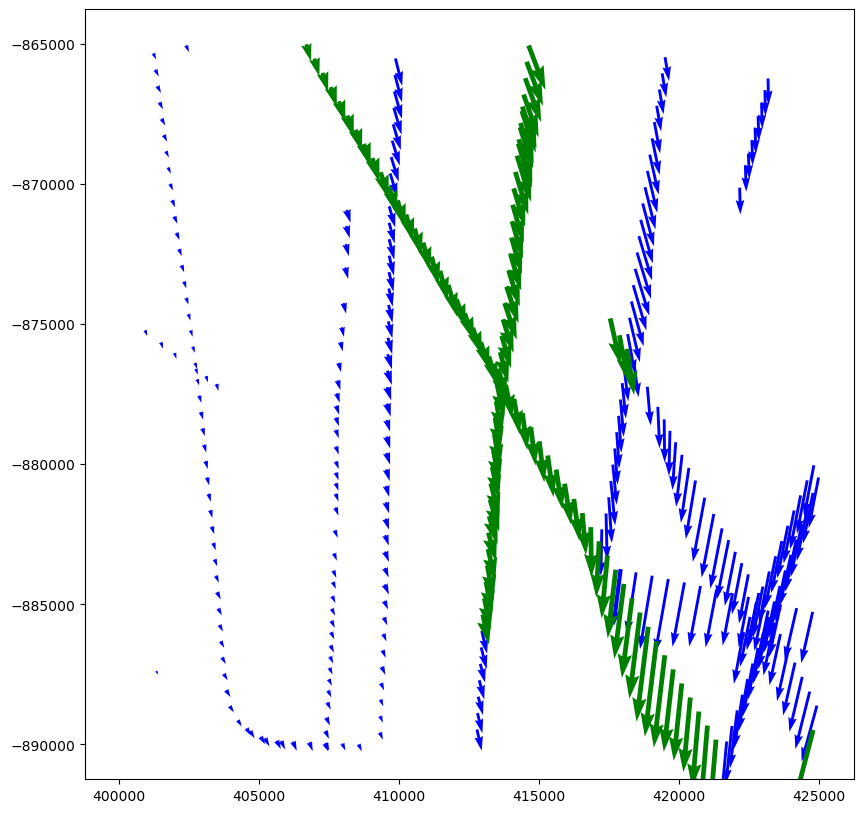

In [64]:
fig, ax = plt.subplots(figsize = (10, 10))

all_indices = list(range(combined_df.shape[0]))

# Define test indices
test_indices = list(list(range(177, 270)))

train_indices = list(set(all_indices) - set(test_indices))

df_train = combined_df.iloc[train_indices]
df_test = combined_df.iloc[test_indices]

ax.quiver(
        df_train["x"], 
        df_train["y"], 
        df_train["xflux"], 
        df_train["yflux"], 
        color = "blue")

ax.quiver(
        df_test["x"], 
        df_test["y"], 
        df_test["xflux"], 
        df_test["yflux"], 
        color = "g")

ax.set_aspect('equal')

# Region C

In [71]:
# Raw data input
file_path = '/home/kim/data/nsidc/antarctica_ice_velocity_450m_v2.nc'
ice_vel_xr = load_and_preprocess_ice_velocity_data(file_path)

corner_regions = pd.read_csv("data/real_data/corners_real_data_regions.csv")

# contains surface, thickness and bedrock
# here we shave off the first two columns as they are not needed
bedmap_points = pd.read_csv('/home/kim/ice_thickness/data/byrd_bedmap_points_clean.csv').iloc[:, 2:]

# for region_name in region_names:
region_names = ["RegionC",]

for region_name in region_names:
    # unpack the region coordinate
    x_min, x_max, y_min, y_max = corner_regions.loc[corner_regions.name == region_name, ["x_min", "x_max", "y_min", "y_max"]].values[0]

    # Step 1: Crop the region
    bedmap_points_region = bedmap_points[
        (bedmap_points["x"] > x_min) & 
        (bedmap_points["x"] < x_max) & 
        (bedmap_points["y"] > y_min) & 
        (bedmap_points["y"] < y_max)]
    
    # Step 2: Subsample here to save compute
    subsample_rate = 20
    bedmap_points_region = bedmap_points_region[::subsample_rate]
    
    # Step 3: Retrieve corresponding surface velocity data
    # Interpolate ice velocity data (VX, VY, ERRX, ERRY) at all combinations of x and y points from the selected region
    ice_vel_xr_interpolated = ice_vel_xr.interp(
        y = (bedmap_points_region["y"]), 
        x = (bedmap_points_region["x"]), 
        method = "quadratic") # interpolation "quadratic"/"nearest"
    
    # 1. Extract the diagonal values from each DataArray
    VX_diag = np.diag(ice_vel_xr_interpolated.VX.values)
    VY_diag = np.diag(ice_vel_xr_interpolated.VY.values)
    ERRX_diag = np.diag(ice_vel_xr_interpolated.ERRX.values)
    ERRY_diag = np.diag(ice_vel_xr_interpolated.ERRY.values)

    # 2. Get the corresponding x and y coordinates
    x_coords = ice_vel_xr_interpolated.x.values
    y_coords = ice_vel_xr_interpolated.y.values

    # 3. Combine into a single DataFrame
    ice_vel_df = pd.DataFrame({
        "x_icevel": x_coords,
        "y_icevel": y_coords,
        "VX": VX_diag,
        "VY": VY_diag,
        "ERRX": ERRX_diag,
        "ERRY": ERRY_diag
    })
    
    combined_df = pd.concat([bedmap_points_region.reset_index(drop = True),
                         ice_vel_df.reset_index(drop = True)],
                        axis = 1) # concat along the columns
    # Check if the x and y coordinates match, and delete redundant columns 
    if (combined_df["x"] == combined_df["x_icevel"]).all() & (combined_df["y"] == combined_df["y_icevel"]).all():
        combined_df = combined_df.drop(columns = ["x_icevel", "y_icevel"]) # inplace column drop

    # Step 4: Compute flux
    combined_df["xflux"] = combined_df["VX"] * combined_df["t"]
    combined_df["yflux"] = combined_df["VY"] * combined_df["t"]
    combined_df["xflux_err"] = combined_df["ERRX"] * combined_df["t"] # We define the error as the produce of the VX error and the thickness 
    combined_df["yflux_err"] = combined_df["ERRY"] * combined_df["t"] # We define the error as the produce of the VY error and the thickness

    # Step 5: for this region, remove 
    combined_df = combined_df[combined_df.source != 'NASA_2017_ICEBRIDGE_AIR_BM3.csv']

    combined_df = combined_df.reset_index(drop = True)

    print(f"Subsampled data shape: {combined_df.shape}")

Subsampled data shape: (585, 17)


# Check which points are too close together

This helps with singulairy of GP matrices.

In [83]:
torch.set_printoptions(precision = 5, sci_mode = False)
def determine_too_close_points(x, threshold):
    """
    Args:
        x (torch.Tensor): Input tensor of shape (n, d). Can be train or test data.
        threshold (float): Distance threshold.
    """
    # Compute pairwise squared Euclidean distances
    dists = torch.cdist(x, x, p = 2)  # shape: [n, n]

    # Set self-distances to a large value like 10
    dists_no_diag = dists + torch.eye(dists.shape[0], device = dists.device) * 1e10

    # Find minimum distance (exlcuding self-distances)
    min_dist = dists_no_diag.min().item()
    print(f"Minimum pairwise distance (in m): {min_dist:.5}")

    # Get index pairs of points where distance is < threshold (True i.e. 1)
    close_pairs = (dists_no_diag < threshold).nonzero(as_tuple = False)
    
    print(f"Close input pairs (threshold {threshold}):")
    print(close_pairs)

    # Track which indices to keep/remove
    to_remove = set()
    seen = set()

    # Greedy removal: remove one point from each pair
    for i, j in close_pairs:
        i = i.item()
        j = j.item()
        if i not in seen and j not in seen:
            # Remove the point with higher number (arbitrary heuristic)
            to_remove.add(j)
            seen.add(i)
            seen.add(j)

    keep_mask = torch.tensor([i not in to_remove for i in range(x.shape[0])], device = x.device)
    x_filtered = x[keep_mask]

    print(f"Number of rows to remove: {len(to_remove)}")
    return sorted(to_remove)

# threshold ist in meters
removal_indices = determine_too_close_points(torch.tensor(combined_df[["x", "y"]].values), threshold = 50) # 50

Minimum pairwise distance (in m): 12.292
Close input pairs (threshold 50):
tensor([[ 89, 178],
        [ 91, 180],
        [ 92, 181],
        [178,  89],
        [179, 317],
        [180,  91],
        [181,  92],
        [260, 520],
        [296, 391],
        [317, 179],
        [334, 504],
        [391, 296],
        [453, 526],
        [504, 334],
        [520, 260],
        [526, 453]])
Number of rows to remove: 8


In [84]:
combined_df_mindist = combined_df.drop(index = removal_indices).reset_index(drop = True)

# Find test train split

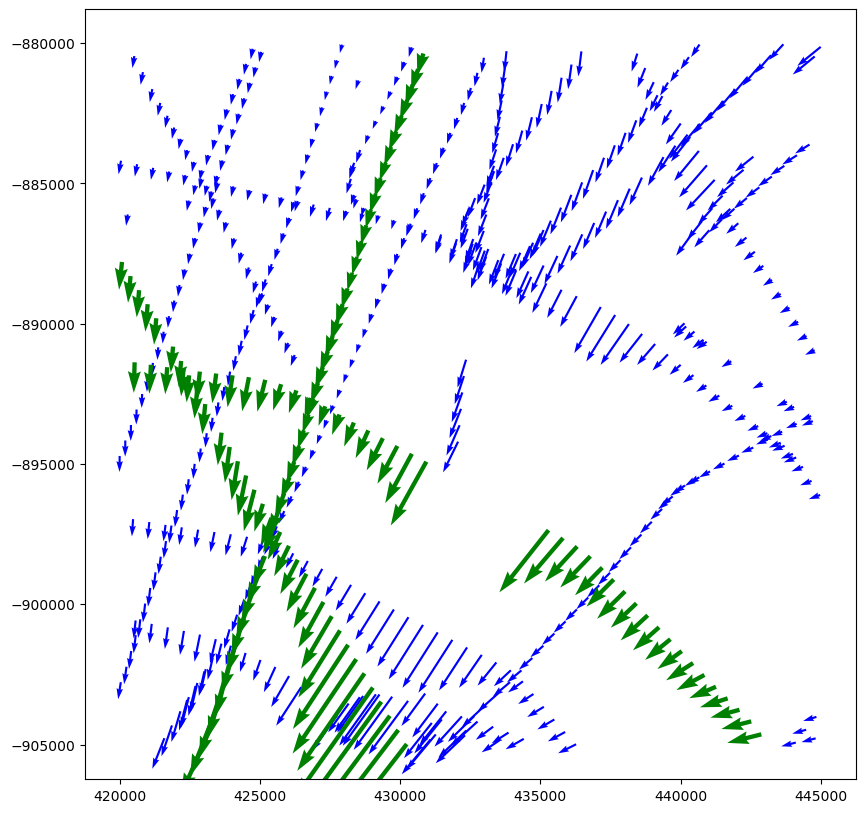

In [85]:
fig, ax = plt.subplots(figsize = (10, 10))

all_indices = list(range(combined_df_mindist.shape[0]))

# Define test indices manually by trial and error
test_indices = list(list(range(107, 146)) # horizontal line
                    + list(range(356, 399)) # vertical line left
                    + list(range(509, 542)) # left corner
                    )

train_indices = list(set(all_indices) - set(test_indices))

df_train = combined_df_mindist.iloc[train_indices]
df_test = combined_df_mindist.iloc[test_indices]

ax.quiver(
        df_train["x"], 
        df_train["y"], 
        df_train["xflux"], 
        df_train["yflux"], 
        color = "blue")

ax.quiver(
        df_test["x"], 
        df_test["y"], 
        df_test["xflux"], 
        df_test["yflux"], 
        color = "g")

ax.set_aspect('equal')

In [86]:
def df_to_tensor(df, x_min, x_max, y_min, y_max, flux_scale, surface_scale = 1000):
    """
    Convert a DataFrame to a tensor and scale as we need.
    
    Parameters:
    - df: DataFrame containing the data
    - x_min, x_max, y_min, y_max: coordinates for normalisation
    - flux_scale: scaling factor for fluxes. We will devide by this.
    - surface_scale: scaling factor for surface. We will devide by this value.
    
    Returns:
    - Tensor with the data
    """
    
    x_tensor = torch.tensor(
        ((df.x - x_min) / (x_max - x_min)).to_numpy(),
        dtype = torch.float32
    )

    y_tensor = torch.tensor(
        ((df.y - y_min) / (y_max - y_min)).to_numpy(),
        dtype = torch.float32
    )

    s_tensor = torch.tensor(
        (df.s / surface_scale).to_numpy(),
        dtype = torch.float32
    )

    xflux_tensor = torch.tensor(
        (df.xflux / flux_scale).to_numpy(),
        dtype = torch.float32
    )

    yflux_tensor = torch.tensor(
        (df.yflux / flux_scale).to_numpy(),
        dtype = torch.float32
    )

    xfluxerr_tensor = torch.tensor(
        (df.xflux_err / flux_scale).to_numpy(),
        dtype = torch.float32
    )

    yfluxerr_tensor = torch.tensor(
        (df.yflux_err / flux_scale).to_numpy(),
        dtype = torch.float32
    )

    return torch.cat(
        (x_tensor.unsqueeze(0), 
         y_tensor.unsqueeze(0), 
         s_tensor.unsqueeze(0), 
         xflux_tensor.unsqueeze(0), 
         yflux_tensor.unsqueeze(0),
         xfluxerr_tensor.unsqueeze(0),
         yfluxerr_tensor.unsqueeze(0)),
        dim = 0
    )

regionc_flux_scale = 200 * 1000

regionc_train_tensor = df_to_tensor(combined_df.iloc[train_indices], x_min, x_max, y_min, y_max, regionc_flux_scale)
regionc_test_tensor = df_to_tensor(combined_df.iloc[test_indices], x_min, x_max, y_min, y_max, regionc_flux_scale)

In [87]:
regionc_train_tensor.T[:, 3].abs().max()
regionc_train_tensor.T[:, 4].abs().max()

tensor(5.71200)

In [88]:
regionc_test_tensor.T[:, 3].abs().max()

tensor(2.97382)

In [89]:
regionc_test_tensor.T[:, 4].abs().max()

tensor(3.62467)

## Export tensors

In [57]:
torch.save(regionc_train_tensor, "data/real_data/regionc_train_tensor.pt")
torch.save(regionc_test_tensor, "data/real_data/regionc_test_tensor.pt")

In [13]:
# color dict to contain all possible datasets
color_dict = {'NASA_2011_ICEBRIDGE_AIR_BM2.csv': 'red', 
              'UTIG_2010_ICECAP_AIR_BM3.csv': 'green', 
              'NASA_2017_ICEBRIDGE_AIR_BM3.csv': 'pink',
              'NASA_2013_ICEBRIDGE_AIR_BM3.csv': 'purple',
              'LDEO_2015_ROSETTA_AIR_BM3.csv': 'blue',
              'BEDMAP1_1966-2000_AIR_BM1.csv': 'orange',
              'UTIG_2004_AGASEA_AIR_BM2.csv': 'brown'}

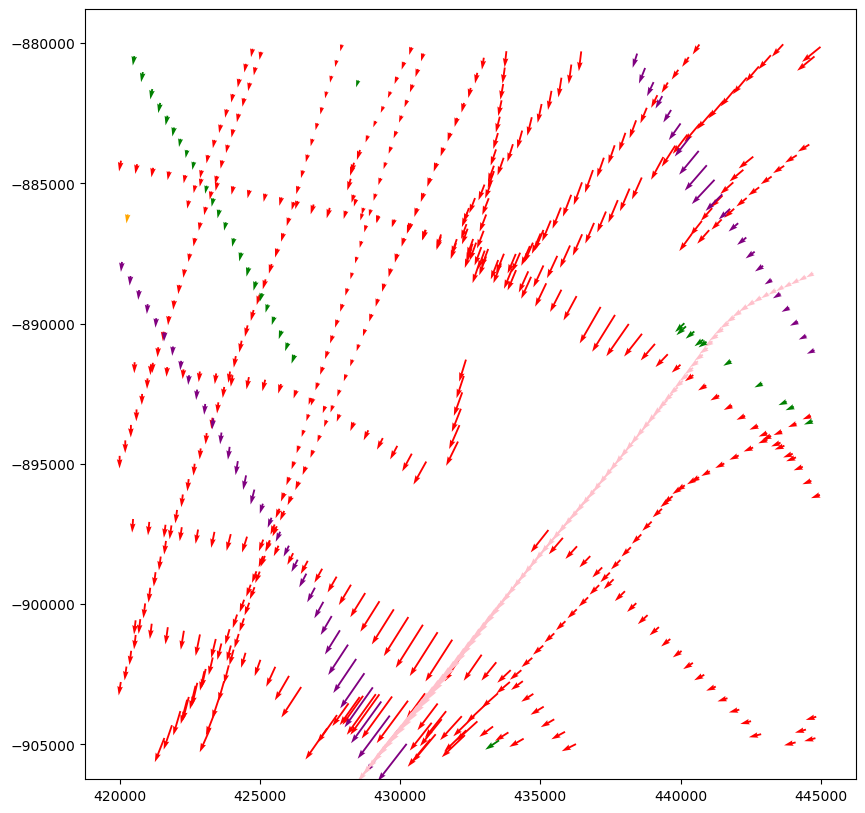

In [15]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.quiver(
        combined_df["x"], 
        combined_df["y"], 
        combined_df["xflux"], 
        combined_df["yflux"], 
        color = [color_dict[category] for category in combined_df["source"]])

ax.set_aspect('equal')

In [18]:
combined_df[combined_df.source != 'NASA_2017_ICEBRIDGE_AIR_BM3.csv']

,lon,lat,x,y,s,t,b,b_inferred,source,VX,VY,ERRX,ERRY,xflux,yflux,xflux_err,yflux_err
0,154.624500,-80.991590,420288.771905,-886103.783624,1078.00,1420.00,-342.00,False,BEDMAP1_1966-2000_AIR_BM1.csv,-24.361429,-164.417506,0.563582,0.700008,-34593.229397,-233472.858387,800.286912,994.010691
1,154.497259,-80.987120,422465.926565,-885609.199197,1024.32,1383.08,-358.76,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv,-29.791877,-152.535344,0.624063,0.731482,-41204.548662,-210968.584216,863.129713,1011.697806
2,154.471592,-80.990682,422694.830224,-885068.539627,1036.54,1344.22,-307.68,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv,-30.076543,-150.519781,0.625838,0.728937,-40429.490203,-202331.700442,841.264060,979.851527
3,154.445882,-80.994239,422924.234653,-884528.030055,1045.91,1399.95,-354.04,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv,-29.877419,-150.023384,0.634151,0.734385,-41826.892435,-210025.236404,887.780386,1028.101898
4,154.420100,-80.997785,423154.869897,-883988.047223,1052.11,1448.66,-396.55,False,NASA_2011_ICEBRIDGE_AIR_BM2.csv,-29.336870,-148.727244,0.660010,0.758993,-42499.150092,-215455.209458,956.130387,1099.522929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,153.597015,-80.851550,442917.907032,-892135.632313,1062.71,956.08,106.64,False,UTIG_2010_ICECAP_AIR_BM3.csv,-215.198926,-105.510652,0.342037,0.391370,-205747.389418,-100876.624449,327.014562,374.180851
660,153.634059,-80.862631,441803.042942,-891336.456044,1006.62,928.66,77.96,False,UTIG_2010_ICECAP_AIR_BM3.csv,-218.680327,-129.476293,0.357943,0.412021,-203079.672641,-120239.454529,332.407424,382.627400
661,153.661504,-80.871881,440927.399900,-890641.764892,1022.49,941.26,81.23,False,UTIG_2010_ICECAP_AIR_BM3.csv,-222.186591,-159.348541,0.393476,0.448128,-209135.351050,-149988.407646,370.363496,421.804550
662,153.674727,-80.876635,440491.375878,-890277.706178,962.86,1021.65,-58.79,False,UTIG_2010_ICECAP_AIR_BM3.csv,-220.117748,-184.082327,0.418610,0.472535,-224883.296927,-188067.709316,427.673249,482.765603


In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))

# Plot data points
ax.scatter(combined_df["x"], combined_df["y"], 
           c = [color_dict[category] for category in combined_df["source"]], 
           s = 2)
combined_df_subset = combined_df[0:1000]
ax.scatter(combined_df_subset["x"], combined_df_subset["y"], color = "black",
           s = 2)

ax.set_aspect('equal')

# To Do

- write pipeline that gets us to byrd_bedmap_clean
- once we are happy with our regions we can save names with region_name and define the test indices, flux_scale and so in some dictionary to just run this script to generate all training and testing data. 

## Take cleaned data set

- Withhold some lines
- Distretise to grid to reduce num of data

In [ ]:
# byrd_bedmap_points = pd.read_csv('/home/kim/ice_thickness/data/byrd_200km.csv')
# clean has 457,451 rows, raw has 465,760 rows
byrd_bedmap_points_clean = pd.read_csv('/home/kim/ice_thickness/data/byrd_bedmap_points_clean.csv')

In [ ]:
byrd_bedmap_points_clean.value_counts("source")

In [ ]:
byrd_bedmap_points_clean[byrd_bedmap_points_clean.source == "BEDMAP1_1966-2000_AIR_BM1.csv"]

In [ ]:
cvals  = [0, # colors so that first value is green (if below 1 m ice thickness)
          1, 250, 500, 750, 1000]

colors = ["#7eb3a1",
          "#bee6fa", "#47bdfc", "#006cef", "#0023c1", "#001079"]

# Create a colormap object
norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))

icethickness_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

# Plot with 500k points

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))

# Plot data points
ax.scatter(byrd_bedmap_points_clean["x"], byrd_bedmap_points_clean["y"], 
           c = byrd_bedmap_points_clean["t"], 
           s = 2,
           cmap = icethickness_cmap, vmin = 0, vmax = 3500)

fig.colorbar(mappable = ax.collections[0], ax = ax)
ax.set_aspect('equal')

In [ ]:
color_dict = {'NASA_2011_ICEBRIDGE_AIR_BM2.csv': 'red', 
              'UTIG_2010_ICECAP_AIR_BM3.csv': 'green', 
              'NASA_2017_ICEBRIDGE_AIR_BM3.csv': 'pink',
              'NASA_2013_ICEBRIDGE_AIR_BM3.csv': 'purple',
              'LDEO_2015_ROSETTA_AIR_BM3.csv': 'blue',
              'BEDMAP1_1966-2000_AIR_BM1.csv': 'orange', # sparse points
              'UTIG_2004_AGASEA_AIR_BM2.csv': 'brown'}

fig, ax = plt.subplots(figsize = (10, 10))

# Plot data points
ax.scatter(byrd_bedmap_points_clean["x"], byrd_bedmap_points_clean["y"], 
           c = [color_dict[category] for category in byrd_bedmap_points_clean["source"]], 
           s = 2)

ax.set_aspect('equal')

# We define the coordinates of our experimental regions

- We write out the polar stereographic coordinates (EPSG:3031) for every square.
- We write the coordinates in kilometer units (* 1000) for easier readability.
- Currently out regions are 25 * 25 km

- subsampling will still keep it irregulaly spaced. Off-grid

In [ ]:
def load_and_preprocess_ice_velocity_data(file_path):
    """
    Load and preprocess ice velocity data from a NetCDF file.
    
    Inputs:
        file_path (str): Path to the NetCDF file.
        
    Returns:
        xarray.DataArray: Preprocessed ice velocity data.
    """
    # Load the NetCDF file
    # loading works with base(Python 3.8.12)
    ice_vel_all_of_antarctica = xr.open_dataset(file_path)

    # Data file is large so crop to the "broader Byrd region" to reduce memory usage
    corners_byrd_regions = pd.read_csv("data/real_data/corners_broader_byrd_region.csv")

    x_min, x_max, y_min, y_max = corners_byrd_regions.loc[corners_byrd_regions.name == "Byrd", ["x_min", "x_max", "y_min", "y_max"]].values[0]

    ice_vel_byrd = ice_vel_all_of_antarctica.sel(x = slice(x_min, x_max), y = slice(y_max, y_min)) # reverse order
    
    return ice_vel_byrd

file_path = '/home/kim/data/nsidc/antarctica_ice_velocity_450m_v2.nc'
ice_vel_xr = load_and_preprocess_ice_velocity_data(file_path)

# Interpolate ice vel in xarray

In [ ]:
bedmap_points_region["y"]

In [ ]:
ice_vel_xr_interpolated = ice_vel_xr.interp(y = (bedmap_points_region["y"]), x = (bedmap_points_region["x"]), method = "nearest")

In [ ]:
# interpolate ice_vel [VX, VY, ERRX, ERRY] to 1 km grid
ice_vel_xr

In [ ]:
bedmap_points_region

In [ ]:
# 25 km / 500 m grid: 50 x 50 grid cells
x_min = 425 * 1000
x_max = 450 * 1000
y_max = -850 * 1000
y_min = -875 * 1000

byrd_bedmap_points_zoom = byrd_bedmap_points_clean[
    (byrd_bedmap_points_clean["x"] > x_min) & 
    (byrd_bedmap_points_clean["x"] < x_max) & 
    (byrd_bedmap_points_clean["y"] > y_min) & 
    (byrd_bedmap_points_clean["y"] < y_max)]

byrd_bedmap_points_zoom

In [ ]:
byrd_bedmap_points_zoom_subsample = byrd_bedmap_points_zoom[::10]

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))


# Plot data points
ax.scatter(byrd_bedmap_points_zoom_subsample["x"], byrd_bedmap_points_zoom_subsample["y"], 
           c = [color_dict[category] for category in byrd_bedmap_points_zoom_subsample["source"]], 
           s = 2)
byrd_bedmap_points_zoom_subset = byrd_bedmap_points_zoom[0:1000]
ax.scatter(byrd_bedmap_points_zoom_subset["x"], byrd_bedmap_points_zoom_subset["y"], color = "black",
           s = 2)

ax.set_aspect('equal')

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))


# Plot data points
ax.scatter(byrd_bedmap_points_zoom["x"], byrd_bedmap_points_zoom["y"], 
           c = [color_dict[category] for category in byrd_bedmap_points_zoom["source"]], 
           s = 2)
byrd_bedmap_points_zoom_subset = byrd_bedmap_points_zoom[0:1000]
ax.scatter(byrd_bedmap_points_zoom_subset["x"], byrd_bedmap_points_zoom_subset["y"], color = "black",
           s = 2)

ax.set_aspect('equal')

# Use natural ordering to subsample the frequency & to seperate train and test.
We can use a larger area but more subsampling! Still no gridding needed... 
Try model with x, y, s input too!